# step1) 데이터셋 구성

## 1-1. 필요 라이브러리 임포트

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from IPython import display
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## 1-2. 데이터 로드
- 이미 3차원이라 따로 reshape 필요없다.

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

### 데이터셋 확인
- CIFAR10은 열 가지 클래스의 이미지를 모아둔 데이터 셋이다.
- 이미지의 크기는 (32,32,3)이다.

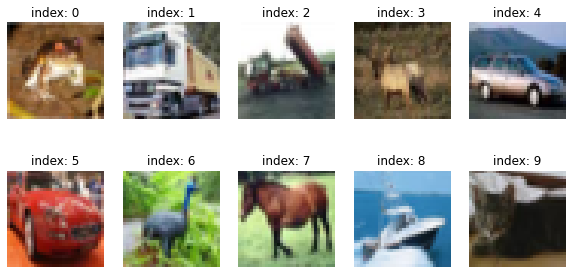

In [4]:
plt.figure(figsize=(10, 5)) # 프레임 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1) # 여러 이미지 띄우기
    plt.imshow(train_x[i].reshape(32, 32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

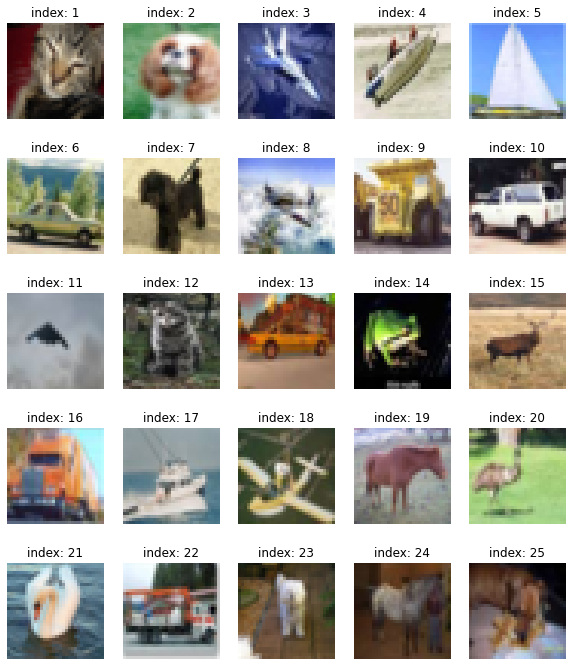

In [7]:
plt.figure(figsize=(10, 12))

for i in range(1,26):
    idx = np.random.randint(0, len(train_x)-1)
    plt.subplot(5,5, i)
    plt.imshow(train_x[idx].reshape(32, 32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## 1-3. 학습 데이터 정규화

- 학습에 사용할 이미지는 [-1, 1] 값으로 정규화를한다.

In [8]:
train_x = (train_x - 127.5) / 127.5

## 1-4. 미니배치 데이터셋 구성

- BUFFER_SIZE는 학습 데이터셋 크기와 같거나 더 크게 설정해야 학습에 효과적이다.

In [24]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
# 10번째 시도
# BATCH_SIZE = 512

- 버퍼사이즈 만큼 데이터셋을 랜덤으로 섞고 배치사이즈에 맞게 자른다.

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [26]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

# step2) 생성자 모델 구현

- 이미지 규격을 확인하기 위해 `tf.random.normal([1,100])`으로 랜덤 노이즈를 생성해 생성자 모델의 입력으로 넣어본다.

In [7]:
# 기존 모델
# def make_generator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Dense layer
#     model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     # Second: Reshape layer
#     model.add(layers.Reshape((8, 8, 256)))

#     # Third: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     # Fourth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     # Fifth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
#                                      activation='tanh'))

#     return model

In [35]:
# 변형 시도 1
# Dense 입력 사이즈와 LeakyReLU alpha=0.2
# 커널 사이즈 4로 스트라이드 2로
# def make_generator_model(alpha=0.2, momentum=0.9):

#     # Start
#     model = tf.keras.Sequential()

#     # First: Dense layer
#     model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization(momentum=0.9))
#     model.add(layers.LeakyReLU(alpha=alpha))

#     # Second: Reshape layer
#     model.add(layers.Reshape((4, 4, 256)))

#     # Third: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.9))
#     model.add(layers.LeakyReLU(alpha=alpha))

#     # Fourth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.9))
#     model.add(layers.LeakyReLU(alpha=alpha))

#     # Fifth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
#                                      activation='tanh'))

#     return model

In [199]:
# # 변형 시도 10
# # Dense 입력 사이즈와 LeakyReLU alpha=0.2
# # 커널 사이즈 5로 스트라이드 2로

def make_generator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*64*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # model.output_shape == (BACHE_SIZE, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha)) 

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [133]:
generator2 = make_generator_model()
generator2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [36]:
generator3 = make_generator_model()
generator3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)        

In [200]:
generator10 = make_generator_model()
generator10.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 4, 4, 256)        

In [235]:
generator11 = make_generator_model()
generator11.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 4, 4, 256)        

In [201]:
noise = tf.random.normal([1, 100])

In [10]:
generated_image = generator(noise, training=False)

In [11]:
generated_image.shape

TensorShape([1, 32, 32, 3])

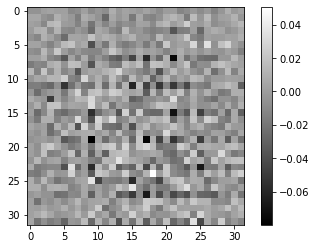

In [12]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

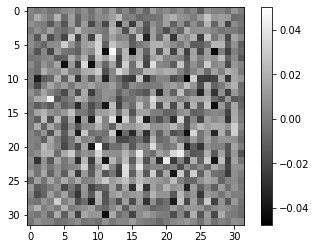

In [134]:
generated_image2 = generator2(noise, training=False)
generated_image2.shape
plt.imshow(generated_image2[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

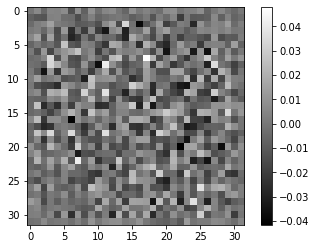

In [38]:
noise = tf.random.normal([1, 100])
generated_image3 = generator3(noise, training=False)
generated_image3.shape
plt.imshow(generated_image3[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

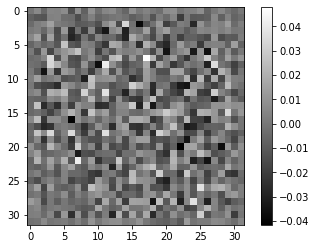

In [38]:
noise = tf.random.normal([1, 100])
generated_image4 = generator4(noise, training=False)
generated_image4.shape
plt.imshow(generated_image3[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

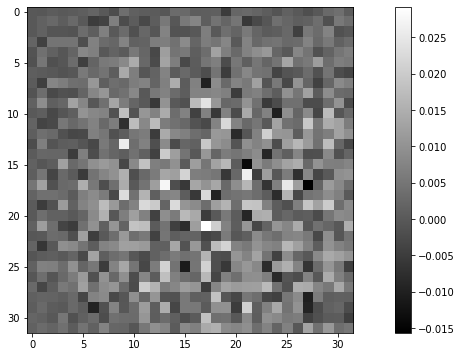

In [202]:
noise = tf.random.normal([1, 100])
generated_image10 = generator10(noise, training=False)
generated_image10.shape
plt.imshow(generated_image10[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

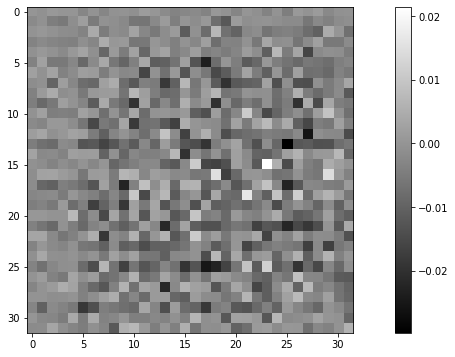

In [236]:
noise = tf.random.normal([1, 100])
generated_image11 = generator11(noise, training=False)
generated_image11.shape
plt.imshow(generated_image11[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# step3) 판별자 모델 구현

- 판별자 모델은 (32, 32, 3)의 이미지를 입력으로 받아 1차원으로 판별 결과를 출력한다.
- 앞서 생성한 랜덤 이미지를 입력으로 넣을 때 수치를 출력하는지 확인해보자.

In [13]:
# 기본 모델 
# def make_discriminator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Conv2D Layer
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Second: Conv2D Layer
#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Third: Flatten Layer
#     model.add(layers.Flatten())

#     # Fourth: Dense Layer
#     model.add(layers.Dense(1))

#     return model

In [39]:
# def make_discriminator_model(alpha=0.2):

#     # Start
#     model = tf.keras.Sequential()

#     # First: Conv2D Layer
#     model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
#     model.add(layers.LeakyReLU(alpha=alpha))
#     model.add(layers.Dropout(0.3))

#     # Second: Conv2D Layer
#     model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=alpha))
#     model.add(layers.Dropout(0.3))
    
#     # Third: Conv2D Layer
#     model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=alpha))
#     model.add(layers.Dropout(0.3))
    
#    # Third: Conv2D Layer
#     model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=alpha))
#     model.add(layers.Dropout(0.3))
    
#     # Third: Flatten Layer
#     model.add(layers.Flatten())
    
#     model.add(layers.Dropout(0.4))
    
#     # Fourth: Dense Layer
#     model.add(layers.Dense(1))

#     return model

In [203]:
# 10번째 시도
def make_discriminator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
 
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [138]:
discriminator2 = make_discriminator_model()

discriminator2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)        

In [40]:
discriminator3 = make_discriminator_model()

discriminator3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)        

In [204]:
discriminator10 = make_discriminator_model()

discriminator10.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [234]:
discriminator11 = make_discriminator_model()
discriminator11.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

In [15]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00022575]], dtype=float32)>

In [139]:
decision2 = discriminator2(generated_image2, training=False)
decision2

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00097413]], dtype=float32)>

In [41]:
decision3 = discriminator3(generated_image3, training=False)
decision3

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00069722]], dtype=float32)>

In [205]:
decision10 = discriminator10(generated_image10, training=False)
decision10

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00162492]], dtype=float32)>

In [ ]:
# dirno = 1
plot_model(generator, show_shapes=True, to_file=f'generator{dirno}.png')

In [ ]:
plot_model(discriminator, show_shapes=True, to_file=f'discriminator{dirno}.png')

## 시행 시도별 모델
- 파라미터 개수가 중복 되는 부분을 제외했다.

|횟수|생성자 모델|판별자 모델|
|----|----|-----|
|첫번째|![model1](dcgan_newimage/modelplot/generator1.png)|![dmodel1](dcgan_newimage/modelplot/discriminator1.png)|
|두번째|![model2](dcgan_newimage/modelplot/generator2.png)|![dmodel2](dcgan_newimage/modelplot/discriminator2.png)|
|네번째|![model3](dcgan_newimage/modelplot/generator4.png)|![dmodel4](dcgan_newimage/modelplot/discriminator4.png)|
|다섯번째|![model4](dcgan_newimage/modelplot/generator5.png)|![dmodel5](dcgan_newimage/modelplot/discriminator5.png)|
|여덟번째|![model5](dcgan_newimage/modelplot/generator8.png)|![dmodel8](dcgan_newimage/modelplot/discriminator8.png)|
|열번째|![model6](dcgan_newimage/modelplot/generator10.png)|![dmodel10](dcgan_newimage/modelplot/discriminator10.png)|

# step4) 손실함수, 최적화함수 구현

- 생성자, 판별자의 손실함수 및 accuracy 지표 구현한다.
- GAN은 손실함수로 Crossentropy를 사용한다.
- `def generator_loss(fake_output)` : Crossentropy를 사용해 생성한 이미지가 판별자를 얼마나 잘 속였는지 파악. -> 작을 수록 좋다.
- `def discriminator_loss(real_output, fake_output)` : 판별자가 진실과 거짓을 얼마나 잘 판별했는지 두개의 Crossentropy의 합으로 가늠. -> 작을 수록 좋다.
- `def discriminator_accuracy(real_output, fake_output)` : 생성자가 이미지를 잘 만들어내면 판별자는 이미지가 진실인지 거짓인지를 판단하기 어려워 확률에 의존하게 된다. 즉, accuracy는 0.5에 수렴할 수록 생성자가 제대로 학습한 것이다.

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [20]:
# 초기모델 optimizer 하이퍼 파라미터
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
#네번째 시도 optimizer 조정

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [212]:
# 열번째 시도 optimizer 조정
# generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5, decay=1e-5)
# discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5, decay=1e-5)

In [237]:
# # 열한번째 시도 optimizer 조정
# generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1= 0.5,beta_2= 0.999)
# discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1= 0.5,beta_2= 0.999)

In [14]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# step5) 훈련과정 기능 함수 구현

## 5-1. 미니배치 실행 함수
- `def train_step(images, gen, dis)` : 미니배치 한 개 훈련 과정
    - 생성자는 노이즈로부터 이미지를 생성해내어서 판별자에게 전달한다.
    - 실제 원본 이미지도 판별자에게 전달한다.
    - 두 출력 값을 통해 loss와 accuracy를 계산하고 gradient를 계산한다.

In [15]:
@tf.function
def train_step(images, gen, dis):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = gen(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = dis(images, training=True)
        fake_output = dis(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

## 5-2. 학습 현황 확인하는 샘플 생성 함수
- `def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1)` : 훈련하면서 생성한 이미지를 시각화하는 함수.
- -1~1 사이로 정규화했던 데이터 셋을 다시 돌려놓는다.

In [16]:
def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1):

    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')

    # 시각화한 이미지 파일에 저장
    try:
        gif_path = '{}/aiffel/enode13/dcgan_newimage/cifar10/generated_samples{:02d}/'.format(os.getenv('HOME'), dirno)
        if not os.path.exists(gif_path):
            os.makedirs(gif_path)
    except OSError:
        print(f'Error : Cannot creating Directory {gif_path}')
    plt.savefig('{}/aiffel/enode13/dcgan_newimage/cifar10/generated_samples{:02d}/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), dirno, epoch, it))

    plt.show()

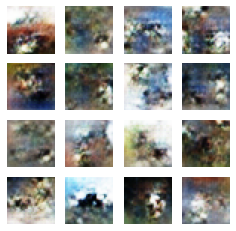

In [110]:
generate_and_save_images(generator, 30, 1, seed)

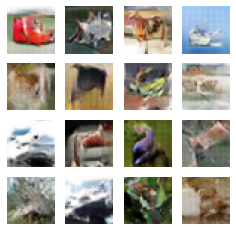

In [231]:
generate_and_save_images(generator3, 100, 1, seed, 2)

## 5-3. 모델 평가지표로 학습 과정 확인 함수
- `def draw_train_history(history, epoch, dirno)` : GAN의 학습 과정을 기록하는 함수
    - 매 step마다 `train_step()` 함수가 반환하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy`를 딕셔너리 키로 삼고 매 학습에서 평가지표 각각의 값을 리스트로 저장한다.
    - 한 epoch 마다 시각화

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, dirno):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['real_accuracy'], color='lightseagreen') 
    plt.plot(history['fake_accuracy'], color='slateblue')  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['real_accuracy','fake_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    # 시각화한 이미지 파일에 저장
    try:
        history_path = '{}/aiffel/enode13/dcgan_newimage/cifar10/training_history{:02d}/'.format(os.getenv('HOME'), dirno)
        if not os.path.exists(history_path):
            os.makedirs(history_path)
    except OSError:
        print(f'Error : Cannot creating Directory {history_path}')
    plt.savefig('{}/aiffel/enode13/dcgan_newimage/cifar10/training_history{:02d}/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), dirno, epoch))
    plt.show()

## 5-4. 체크포인트
- 학습 결과를 체크포인트로 저장하자.
- 앞서 정의한 optimizer 설정과 생성자, 판별자 모델을 입력으로 받아 `tf.train.Checkpoint` 객체를 생성한다.

In [148]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [149]:
checkpoint_dir = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator2,
                                 discriminator=discriminator2)

In [54]:
checkpoint_dir = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator3,
                                 discriminator=discriminator3)

In [218]:
checkpoint_dir = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator10,
                                 discriminator=discriminator10)

In [242]:
dirno = 11

In [243]:
checkpoint_dir = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator11,
                                 discriminator=discriminator11)

## 4번째 시도 체크포인트 불러와서 다시 진행

In [18]:
new_generator = tf.keras.models.load_model('saved_model/gen4')
new_discriminator = tf.keras.models.load_model('saved_model/dis4')

In [19]:
dirno = 4
#네번째 시도 optimizer 조정

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
checkpoint_dir = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=new_generator,
                                 discriminator=new_discriminator)

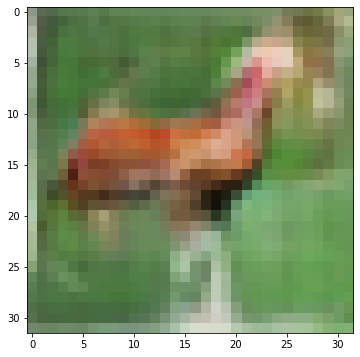

In [59]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

new_generator = checkpoint.generator
new_discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = new_generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# step6) 학습 과정 진행
- `def make_gif(dirno)` : 학습 과정 동안 생성한 이미지들로 gif 파일을 생성해 학습 진행 과정을 시각화
- `def train(dataset, epochs, save_every, dirno, genno, disno)` : 실제 학습 진행하는 함수. `save_every`에 지정한 epochs 때 마다 저장한다.

학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [20]:
def train(dataset, epochs, save_every, dirno, genno, disno):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch, genno, disno)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(genno, epoch+1, it+1, seed, dirno)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(genno, epochs, it, seed, dirno)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, dirno)

In [21]:
save_every = 10

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 6-1. 하이퍼 파라미터 튜닝

In [22]:
EPOCHS = 256
# 하이퍼 파라미터 튜닝하고 학습 반복할 때 마다 ++ 할 것

In [27]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

## 두번째 시도

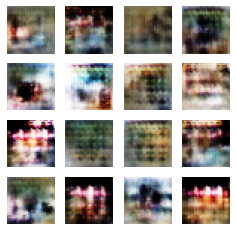

Time for training : 1673 sec


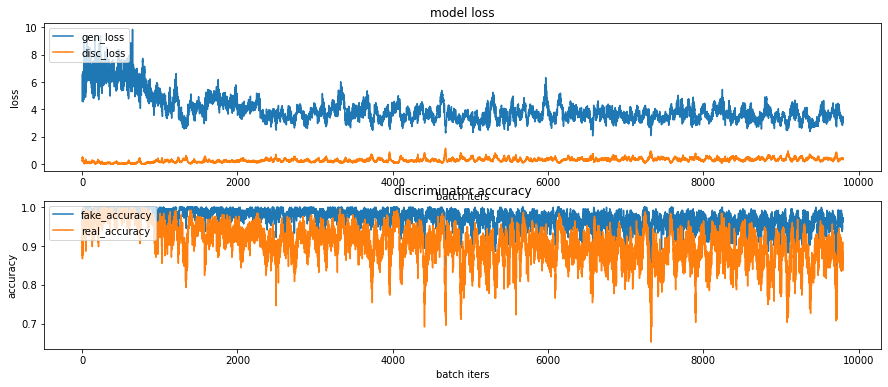

CPU times: user 27min 48s, sys: 24.8 s, total: 28min 13s
Wall time: 27min 54s


In [168]:
%%time
train(train_dataset, EPOCHS, save_every, dirno, generator2, discriminator2)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 세번째 시도

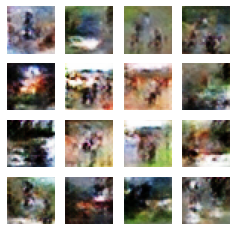

Time for training : 3361 sec


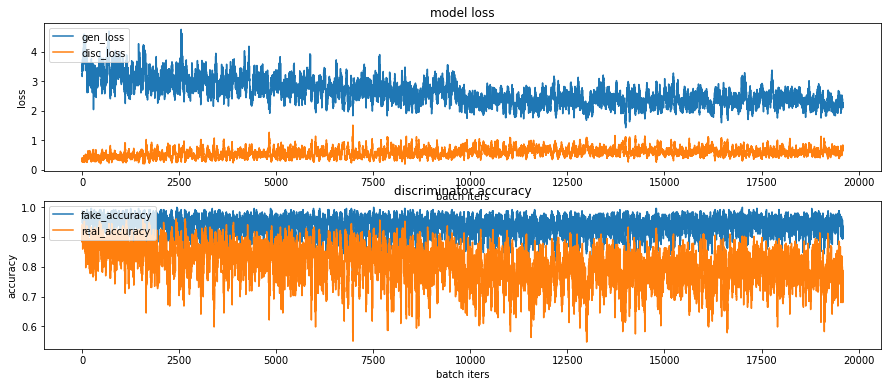

CPU times: user 55min 52s, sys: 47.9 s, total: 56min 40s
Wall time: 56min 2s


In [173]:
%%time
train(train_dataset, EPOCHS, save_every, dirno, generator2, discriminator2)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 네번째 시도

In [57]:
EPOCHS = 256
# 하이퍼 파라미터 튜닝하고 학습 반복할 때 마다 ++ 할 것
dirno = 4

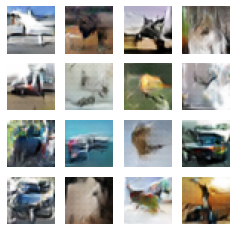

Time for training : 11056 sec


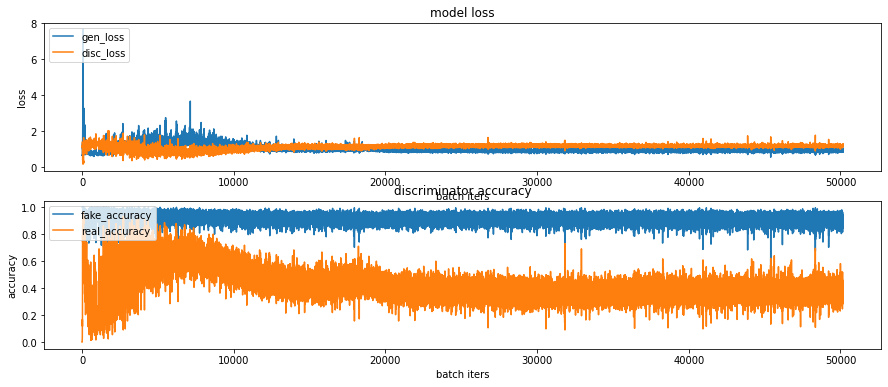

CPU times: user 3h 3min 15s, sys: 1min 59s, total: 3h 5min 14s
Wall time: 3h 4min 18s


In [58]:
%%time
train(train_dataset, EPOCHS, save_every, dirno, generator3, discriminator3)

## 열번째 시도

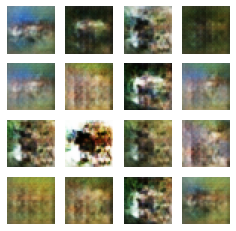

Time for training : 5493 sec


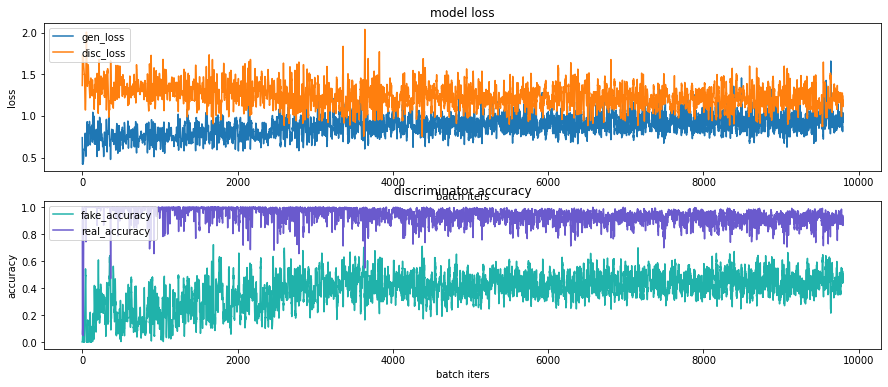

CPU times: user 1h 31min 3s, sys: 58.8 s, total: 1h 32min 2s
Wall time: 1h 31min 33s


In [222]:
%%time
train(train_dataset, EPOCHS, save_every, 10, generator10, discriminator10)

In [247]:
EPOCHS

256

## 4번째 시도 3번째 재학습

- 4번째 시도가 괜찮은 것 같아서 계속 학습을 이어가보기로 했다.

- 체크포인트를 통해 모델이 로드되었으면 로드된 모델의 파라미터 상태에서 훈련 재개 가능

In [71]:
checkpoint_dir

'/aiffel/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints4'

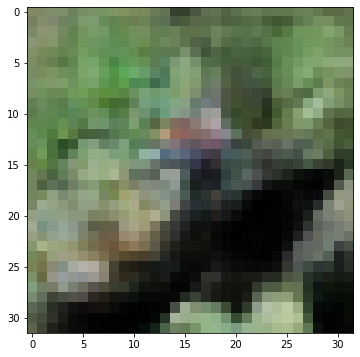

In [72]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

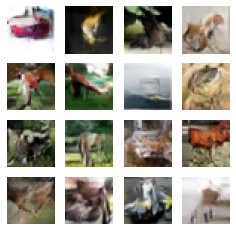

Time for training : 14380 sec


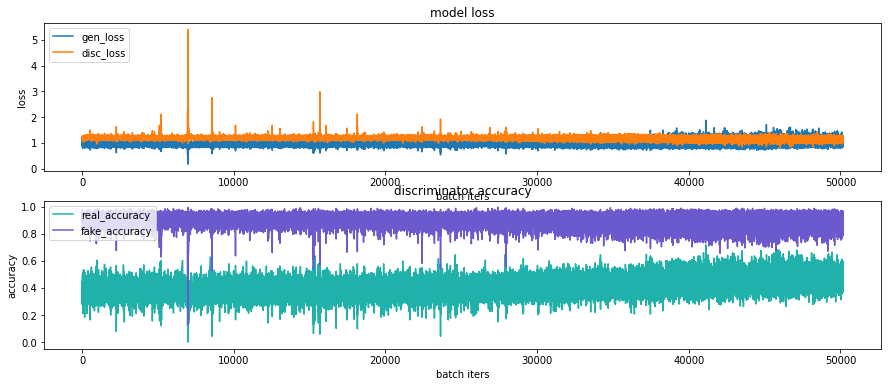

CPU times: user 3h 57min 4s, sys: 2min 33s, total: 3h 59min 38s
Wall time: 3h 59min 42s


In [60]:
%%time
train(train_dataset, EPOCHS, save_every, 43, new_generator, new_discriminator)

- 4번째 모델에 추가적으로 학습을 진행했더니 좀 더 뚜렷한 이미지가 보이는 것 같다!
- accuracy도 많이 낮아지고 있다.

In [63]:
make_gif(43)

## 6-1. epoch별 모델 생성 이미지 시각화

In [62]:
def make_gif(dirno):
    anim_file = os.getenv('HOME')+f'/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan{dirno}.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('{}/aiffel/enode13/dcgan_newimage/cifar10/generated_samples{:02d}/sample*.png'.format(os.getenv('HOME'), dirno))
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [102]:
!ls -l ~/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan.gif

-rw-r--r-- 1 root root 1272077 Aug 29 18:58 /aiffel/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan.gif


In [69]:
make_gif(7)

In [67]:
!ls -l ~/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan7.gif

-rw-r--r-- 1 root root 800192 Sep  2 04:58 /aiffel/aiffel/enode13/dcgan_newimage/cifar10/cifar_dcgan7.gif


# step7) GAN 훈련과정 개선 (optional)

## 7-1. 요약

|시도|모델 구성|특징|Epochs|결과|
|:----|:------------|------------|---------|--------|
|첫번째|생성자 : ConvT 2계층 (8,8,256) → (8,8,128) → (16,16,64) → (32,32,3) <br/> 판별자 : Conv+LeakyReLU+Dropout 2계층 (32,32,3) → (16,16,64) → (8,8,128) → 8192 → 1||50|![cifar1](dcgan_newimage/cifar10/cifar_dcgan.gif)|
|두번째|생성자 : (4,4,256) → (8,8,128) → (16,16,128) → (32,32,3) <br/>판별자 : (32,32,3) → (16,16,64) → (8,8,128) → (4,4,128) → (2,2,256) → 1024 → 1|모델을 더 개선했다.|50|![cifar1](dcgan_newimage/cifar10/cifar_dcgan2.gif)|
|세번째|두번째 시도에 이어서 학습 했다.|Epochs 수를 늘려봤다.|100|![cifar1](dcgan_newimage/cifar10/cifar_dcgan3.gif)|
|네번째|생성자 : (4,4,256) → (8,8,128) → (16,16,128) → (32,32,3)<br/> 판별자 : (32,32,3) → (16,16,64) → (8,8,128) → (4,4,128) → (2,2,256) → 1024 → 1|LeakyReLU에 alpha=0.2를 사용했다.<br/> Adam 파라미터 조정 lr=0.0002, beta_1=0.5|256|![cifar1](dcgan_newimage/cifar10/cifar_dcgan4.gif)|
|네번째_3|생성자 : (4,4,256) → (8,8,128) → (16,16,128) → (32,32,3)<br/> 판별자 : (32,32,3) → (16,16,64) → (8,8,128) → (4,4,128) → (2,2,256) → 1024 → 1|세번째 추가학습|256|![cifar4-3](dcgan_newimage/cifar10/cifar_dcgan43.gif)|
|여덟번째|BN에 momentum=0.9를 사용했다.|lr=1e-4, beta_1=0.5, decay=1e-5 lr=1e-3, beta_1=0.5, decay=1e-5|256|![cifar1](dcgan_newimage/cifar10/cifar_dcgan8.gif)|
|아홉번째| 판별자 : (32,32,3) → (16,16,64) → (8,8,256) → 16384 → 1<br/>판별자 모델 계층을 하나 줄이고 Flatten 계층에서 Dropout을 제외했다.|epochs 수가 적긴 했지만 너무 학습이 안되는 모습을 보였다.<br/>lr=0.0002, beta_1=0.5, momentum=0.4|100|![cifar1](dcgan_newimage/cifar10/cifar_dcgan9.gif)|
|열네번째|생성자 : (4,4,256) → (8,8,128) → (16,16,128) → (32,32,3)<br/> 판별자 : (32,32,3) → (16,16,64) → (8,8,128) → 8192 → 1|생성자 beta_1이 판별자 beta_1보다 크게 했다.<br/>생성자(lr=1e-4, beta_1=0.5)<br/>판별자(lr=1e-3, beta_1=0.3)|100|![cifar14](dcgan_newimage/cifar10/cifar_dcgan14.gif)|

## 7-2. 실험 과정

## 첫번째 시도
- 생성자 : ConvT 2계층
    - (8,8,256) → (8,8,128) → (16,16,64) → (32,32,3)
- 판별자 : Conv+LeakyReLU+Dropout 2계층
    - (32,32,3) → (16,16,64) → (8,8,128) → 8192 → 1
- Epoch 50까지 훈련한 이미지

![mnist](dcgan_newimage/cifar10/cifar_dcgan.gif)

## 두번째 시도
- 모델 개선
- 생성자
    - (4,4,256) → (8,8,128) → (16,16,128) → (32,32,3)
- 판별자
    - (32,32,3) → (16,16,64) → (8,8,128) → (4,4,128) → (2,2,256) → 1024 → 1

![mnist](dcgan_newimage/cifar10/cifar_dcgan2.gif)

## 세번째 시도
- 두번째 모델에 epoch을 조금 늘려서 진행해보았다.

In [174]:
make_gif(dirno)

![cifar](dcgan_newimage/cifar10/cifar_dcgan3.gif)

## 네번째 시도
- 모델을 조금 고쳐봤다
- LeakyReLU 레이어에 alpha 값으로 0.2를 지정했다.
- 옵티마이저 하이퍼 파라미터 값도 수정했다. lr=0.0002, beta_1=0.5
- 비록 real accuracy만 확실하게 0.5에 수렴하는 모습을 보이고 있지만 지금까지 시도한 모델 중에 가장 그럴싸한 이미지를 많이 만들어 냈다.
- fake accuracy도 나름.. 천천히 우하향하고 있다.

![cifar](dcgan_newimage/cifar10/cifar_dcgan4.gif)

![cifar](dcgan_newimage/cifar10/training_history04/train_history_0255.png)

## 암흑기
- 5, 6, 7번째 시도는 안하느니만 못했다.
- 여섯번째 시도 optimizer 조정 
    - 생성자 : lr=0.0002, beta_1=0.5, decay=6e-8
    - 판별자 : lr=0.0002, beta_1=0.996, decay=6e-8
- 일곱번째 시도
    - 생성자 : lr=0.0002, beta_1=0.5, decay=1e-5
    - 판별자 : lr=0.0002, beta_1=0.996, decay=1e-5
![trial7](dcgan_newimage/cifar10/training_history07/train_history_0021.png)

![cifar](dcgan_newimage/cifar10/training_history06/train_history_0046.png)

- 망한 생성 이미지를 보고 가자~
- 약간 광란의 EDM 파티 느낌 나고 좋다^^

![cifar](dcgan_newimage/cifar10/cifar_dcgan6.gif)

## 여덟번째 시도
- 다른 노트북에서 진행해서 결과만 보도록하자.
- 생성자 : lr=1e-4, beta_1=0.5, decay=1e-5
- 판별자 : lr=1e-3, beta_1=0.5, decay=1e-5

![cifar](dcgan_newimage/cifar10/cifar_dcgan8.gif)
![cifar](dcgan_newimage/cifar10/training_history08/train_history_0255.png)

## 아홉번째 시도
- 판별자 모델의 계층을 하나 줄이고 Flatten 계층에서 Dropout을 제외했다.
- epochs 수가 적긴 했지만 너무 학습이 안되는 모습을 보였다.

![cifar](dcgan_newimage/cifar10/cifar_dcgan9.gif)
![cifar](dcgan_newimage/cifar10/training_history09/train_history_0099.png)

## 열네번째 시도
- 간혹 생성자와 판별자의 beta_1 값을 다르게 하는 경우를 볼 수 있어서 이를 다르게 하고 진행해보려고 했다.
- 생성자 beta > 판별자 beta
    - 생성자 : lr=1e-4, beta_1=0.5
    - 판별자 : lr=1e-3, beta_1=0.3
- 그래프를 보면 특정 샘플에서 real accuracy와 fake accuracy가 현저히 낮아지는 구간을 볼 수 있는데 전반적으로 fake accuracy가 더 많이 나빠진다.
- beta_1 값이 더 작은 판별자 쪽이 loss가 중간중간 급증한 모습을 볼 수 있었다.
![14gif](dcgan_newimage/cifar10/cifar_dcgan14.gif)
![14history](dcgan_newimage/cifar10/training_history14/train_history_0255.png)


## 열다섯번째 시도
- 생성자 beta < 판별자 beta
    - 생성자 : lr=1e-4, beta_1=0.3
    - 판별자 : lr=1e-3, beta_1=0.5


![15gif](dcgan_newimage/cifar10/cifar_dcgan15.gif)
![15history](dcgan_newimage/cifar10/training_history15/train_history_0255.png)


## 네번째 시도 재학습
- fake accuracy도 안정적으로 떨어지고 있다.
![43gif](dcgan_newimage/cifar10/cifar_dcgan43.gif)
![43history](dcgan_newimage/cifar10/training_history43/train_history_0255.png)

## 7-3. 저장한 체크 포인트 로드해서 진행

In [174]:
dirno = 41

In [175]:
checkpoint_dir = f'/aiffel/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'

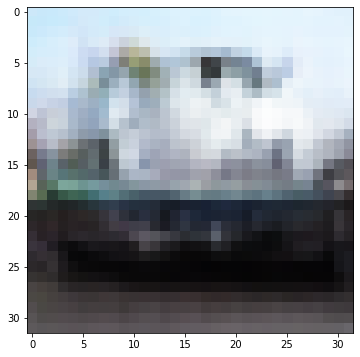

In [193]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

- 나름 배를 만들어 냈다.

In [253]:
drino = 4
checkpoint_dir = f'/aiffel/aiffel/enode13/dcgan_newimage/cifar10/training_checkpoints{dirno}'

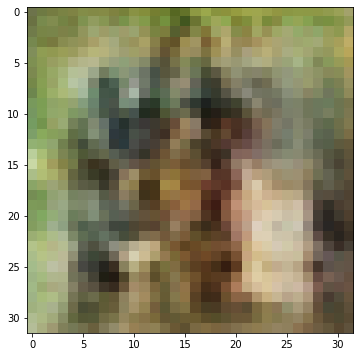

In [261]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [164]:
# 최적화 함수만 조절한 후 이어서 학습
generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
train(train_dataset, EPOCHS, save_every, dirno, generator, discriminator)

## 7-4. 옵티마이저 하이퍼 파라미터를 조정하고 4번째 모델을 이어서 학습한 결과

In [194]:
make_gif(41)

- 파라미터가 적절하지 않았던 듯 하다. lr을 5e-4 정도로 소폭 상승시켰었는데 오히려 노이즈가 많아졌다.

![cifar](dcgan_newimage/cifar10/cifar_dcgan41.gif)

In [195]:
make_gif(42)

![cifar](dcgan_newimage/cifar10/cifar_dcgan42.gif)

### 4번째 시도 코드를 잃어버려서 모델 구조 저장하는 코드

In [251]:
generator3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)        

In [263]:
generator3.save('saved_model/gen4')

INFO:tensorflow:Assets written to: saved_model/gen4/assets


In [264]:
discriminator3.save('saved_model/dis4')

INFO:tensorflow:Assets written to: saved_model/dis4/assets


In [252]:
discriminator3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)        

# 회고
- 기본 베이스 라인 모델로는 이미지가 너무 뭉개지고 특정 색상이 강하게 튀었다.
- 생성자를 한층 더 쌓고 LeakyReLU에 alpha 값을 넣는 것 만으로도 생성 결과가 꽤 준수해졌다.
- beta_1 값은 낮은 경우가 더 준수한 결과를 보였다.
- 전반적으로 생성자 모델을 깊게 쌓는 것이 더 좋은 결과를 얻을 수 있었다.
- 한 번 학습하는데 꽤 오래 걸려서 서태원님과 같이 토론해보고 경우의 수를 나눠서 하이퍼 파라미터 튜닝을 진행했다.
- 하도 반복해서 수정하다보니까 나중에는 내가 뭘 고치고 있는건지 조금 혼미했다. 진행했던 결과를 잘 트래킹하고 변인을 제어하면서 실험해봐야겠다.
- 초반에 시간을 들여서 모델 학습 부터 결과 도출까지 모듈화 하는 습관을 가져야겠다.
- 각각의 하이퍼 파라미터가 어떤 역할을 하는지를 조금 더 파악해야겠다. CS231n에서 그렇구나 하고 넘어갔던 부분을 막상 조절하려니 어떤 결과가 나올지 제대로 된 확신이 없어서 튜닝에 어려움을 겪었다.
- 육안으로 보기에 비슷한 이미지를 생성하는 모델과 실제 fake accuracy가 많이 낮아지는 모델이 달랐다. GAN의 성능 평가에 사용되는 다른 지표가 있는지 더 찾아봐야겠다.

- [How To Train a GAN](https://github.com/soumith/ganhacks)
- [10 Lessons I Learnd Training GANs](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)